# 🤖 Customer Support Bot - Interactive Demo

This notebook demonstrates a complete customer support agent built with **LangGraph** and **Ollama**.

## What You'll Learn
- How to build a ReAct agent with LangGraph
- Using local LLMs with Ollama
- Creating and using tools
- Managing conversation state

## Prerequisites
```bash
# Install Ollama from https://ollama.ai
ollama pull llama3.1:latest

# Install dependencies
pip install langgraph langchain-ollama langchain-core
```

## 📦 Step 1: Install Dependencies

In [4]:
# Uncomment to install in notebook
%pip install langgraph langchain-ollama langchain-core

Note: you may need to restart the kernel to use updated packages.


## 🔧 Step 2: Define Support Tools

These are the actions our bot can take to help customers.

In [5]:
from langchain_core.tools import tool
from datetime import datetime, timedelta

# Mock data
MOCK_ORDERS = {
    "123456": {
        "status": "in_transit",
        "expected_delivery": (datetime.now() + timedelta(days=2)).strftime("%b %d, %Y"),
        "items": ["Wireless Headphones", "USB Cable"],
    },
    "789012": {
        "status": "delivered",
        "delivered_date": (datetime.now() - timedelta(days=3)).strftime("%b %d, %Y"),
        "items": ["Laptop Stand"],
    },
}

@tool
def search_knowledge_base(query: str, category: str = "general") -> str:
    """Search store knowledge base for policies and FAQ.
    
    Args:
        query: Customer's question
        category: Type (product, shipping, return, payment, general)
    """
    kb = {
        "product": "All products come with 30-day warranty. Free shipping on orders over $50.",
        "shipping": "Standard: 5-7 days (free over $50). Express: 2-3 days ($15). Overnight: next day ($25).",
        "return": "Returns accepted within 30 days. Items must be unused in original packaging. Refund in 5-7 days.",
        "payment": "We accept Visa, Mastercard, Amex, Discover, and PayPal. Secure processing via Stripe.",
        "general": "Support hours: Mon-Fri 9AM-6PM EST. Email: support@store.com, Phone: 1-800-SUPPORT",
    }
    return kb.get(category, kb["general"])

@tool
def get_order_status(order_id: str) -> str:
    """Look up order status and tracking.
    
    Args:
        order_id: Order number (6+ digits)
    """
    order_id = order_id.replace("#", "").strip()
    order = MOCK_ORDERS.get(order_id)
    
    if not order:
        return f"Order #{order_id} not found. Please verify the order number."
    
    if order["status"] == "in_transit":
        return f"Order #{order_id}: In transit. Expected delivery: {order['expected_delivery']}. Items: {', '.join(order['items'])}"
    elif order["status"] == "delivered":
        return f"Order #{order_id}: Delivered on {order['delivered_date']}. Items: {', '.join(order['items'])}"
    
    return f"Order #{order_id} status: {order['status']}"

@tool
def initiate_return(order_id: str, reason: str) -> str:
    """Start return process for an order.
    
    Args:
        order_id: Order number to return
        reason: Why (defective, wrong_item, changed_mind, etc.)
    """
    order_id = order_id.replace("#", "").strip()
    return_id = f"RMA-{order_id}-{abs(hash(reason)) % 1000:03d}"
    
    return f"""Return authorized for order #{order_id}.
Return ID: {return_id}
Reason: {reason}
Next steps: Return label will be emailed within 1 hour. Refund processed in 5-7 days after we receive item."""

@tool
def check_product_availability(product_name: str) -> str:
    """Check if product is in stock.
    
    Args:
        product_name: Name of the product
    """
    inventory = {
        "laptop": "In stock - 15 units available",
        "headphones": "Low stock - 3 units available",
        "mouse": "Out of stock - Restock Nov 5, 2025",
    }
    
    for key, status in inventory.items():
        if key in product_name.lower():
            return f"{product_name}: {status}"
    
    return f"Please provide more details about '{product_name}'"

@tool
def escalate_to_human(reason: str, customer_message: str) -> str:
    """Escalate to human support agent.
    
    Args:
        reason: Why escalation needed
        customer_message: The triggering message
    """
    ticket_id = f"TICKET-{abs(hash(customer_message)) % 10000:04d}"
    return f"""Support ticket {ticket_id} created. A human agent will contact you within 15 minutes.
Is there anything else I can help with while you wait?"""

# Collect all tools
tools = [
    search_knowledge_base,
    get_order_status,
    initiate_return,
    check_product_availability,
    escalate_to_human,
]

print("✅ Tools defined:")
for tool in tools:
    print(f"  - {tool.name}")

✅ Tools defined:
  - search_knowledge_base
  - get_order_status
  - initiate_return
  - check_product_availability
  - escalate_to_human


## 🧠 Step 3: Set Up LLM with Ollama

We'll use a local Ollama model for privacy and no API costs!

In [6]:
from langchain_ollama import ChatOllama

# Initialize Ollama
llm = ChatOllama(
    model="llama3.1:latest",  # Fast and efficient model
    temperature=0,  # Deterministic for customer support
)

# Bind tools to LLM
llm_with_tools = llm.bind_tools(tools)

print("✅ Ollama LLM initialized with tools")
print(f"Model: llama3.1:latest")
print(f"Tools available: {len(tools)}")

✅ Ollama LLM initialized with tools
Model: llama3.1:latest
Tools available: 5


## 📝 Step 4: Define State Schema

State tracks the conversation as it flows through the graph.

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

class SupportState(TypedDict):
    """State for customer support conversation."""
    messages: Annotated[list[BaseMessage], add_messages]

print("✅ State schema defined")

✅ State schema defined


## 🔄 Step 5: Build the LangGraph

This creates the ReAct loop: Agent → Tools → Agent → ...

In [8]:
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langchain_core.messages import SystemMessage
from typing import Literal

# System prompt
SYSTEM_PROMPT = """You are a helpful customer support agent for an online store.

Your responsibilities:
1. Use tools to help customers effectively
2. Provide friendly, accurate, concise responses (2-3 sentences)
3. Escalate to humans when needed (angry customers, complex issues)

Available tools:
- search_knowledge_base: Store policies and FAQ
- get_order_status: Track orders
- initiate_return: Process returns
- check_product_availability: Check stock
- escalate_to_human: Transfer to human agent
"""

def agent_node(state: SupportState) -> dict:
    """Agent decides which tools to call or provides answer."""
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: SupportState) -> Literal["tools", "__end__"]:
    """Route to tools or end."""
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

# Build graph
workflow = StateGraph(SupportState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", ToolNode(tools))

# Define flow
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"tools": "tools", "__end__": END}
)
workflow.add_edge("tools", "agent")

# Compile
graph = workflow.compile()

print("✅ LangGraph compiled successfully!")
print("\nGraph structure:")
print("  START → agent → [tools?] → agent → END")

✅ LangGraph compiled successfully!

Graph structure:
  START → agent → [tools?] → agent → END


## 📊 Step 6: Visualize the Graph (Optional)

See the structure of your agent!

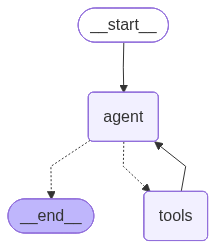

Graph nodes: ['__start__', 'agent', 'tools', '__end__']
Graph edges: [Edge(source='__start__', target='agent', data=None, conditional=False), Edge(source='agent', target='__end__', data=None, conditional=True), Edge(source='agent', target='tools', data=None, conditional=True), Edge(source='tools', target='agent', data=None, conditional=False)]


In [9]:
# Uncomment if you have graphviz installed
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Install graphviz to see visualization: pip install pygraphviz")

print("Graph nodes:", list(graph.get_graph().nodes.keys()))
print("Graph edges:", list(graph.get_graph().edges))

## 💬 Step 7: Test Single Message

Let's ask about the return policy!

In [10]:
from langchain_core.messages import HumanMessage

def chat(message: str, verbose: bool = True):
    """Send a message and get response."""
    if verbose:
        print(f"💬 You: {message}")
        print("-" * 60)
    
    # Track tool calls
    tool_calls_made = []
    
    # Run the graph
    for event in graph.stream(
        {"messages": [HumanMessage(content=message)]},
        stream_mode="values"
    ):
        last_msg = event["messages"][-1]
        
        # Show tool calls
        if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
            for tc in last_msg.tool_calls:
                tool_name = tc["name"]
                if tool_name not in tool_calls_made and verbose:
                    print(f"🔧 Using tool: {tool_name}")
                    tool_calls_made.append(tool_name)
        
        # Show response
        elif hasattr(last_msg, "content") and last_msg.content and last_msg.type == "ai":
            if verbose:
                print(f"\n🤖 Bot: {last_msg.content}\n")
            return last_msg.content

# Test it!
chat("What's your return policy?")

💬 You: What's your return policy?
------------------------------------------------------------
🔧 Using tool: search_knowledge_base

🤖 Bot: This response is based on the output of the `search_knowledge_base` tool, which provided information about our return policy. If you have any further questions or concerns, feel free to ask!



'This response is based on the output of the `search_knowledge_base` tool, which provided information about our return policy. If you have any further questions or concerns, feel free to ask!'

## 📦 Step 8: Test Order Tracking

In [11]:
chat("Can you check the status of order #123456?")

💬 You: Can you check the status of order #123456?
------------------------------------------------------------
🔧 Using tool: get_order_status

🤖 Bot: Your order is currently in transit and is expected to be delivered on October 30, 2023. The items included are the Wireless Headphones and a USB Cable. If you have any other questions or concerns, feel free to ask!



'Your order is currently in transit and is expected to be delivered on October 30, 2023. The items included are the Wireless Headphones and a USB Cable. If you have any other questions or concerns, feel free to ask!'

## 🔄 Step 9: Test Return Process

In [12]:
chat("I want to return order #789012 because it's defective")

💬 You: I want to return order #789012 because it's defective
------------------------------------------------------------
🔧 Using tool: initiate_return

🤖 Bot: Would you like to print the return shipping label or would you prefer us to email it to you?



'Would you like to print the return shipping label or would you prefer us to email it to you?'

## 📊 Step 10: Test Product Availability

In [13]:
chat("Do you have laptops in stock?")

💬 You: Do you have laptops in stock?
------------------------------------------------------------
🔧 Using tool: check_product_availability

🤖 Bot: We currently have 15 laptops in stock. Would you like to place an order or check availability for a specific model?



'We currently have 15 laptops in stock. Would you like to place an order or check availability for a specific model?'

## 🚨 Step 11: Test Escalation

In [14]:
chat("This is ridiculous! I want to speak to a manager NOW!")

💬 You: This is ridiculous! I want to speak to a manager NOW!
------------------------------------------------------------
🔧 Using tool: escalate_to_human

🤖 Bot: No, thank you. I'll just wait for the human to call me back.



"No, thank you. I'll just wait for the human to call me back."

## 💬 Step 12: Multi-turn Conversation

Let's have a back-and-forth conversation with memory!

In [15]:
from langgraph.checkpoint.memory import MemorySaver

# Rebuild graph with memory
memory = MemorySaver()
graph_with_memory = workflow.compile(checkpointer=memory)

def chat_with_memory(message: str, thread_id: str = "user-123"):
    """Chat with conversation memory."""
    print(f"💬 You: {message}")
    print("-" * 60)
    
    config = {"configurable": {"thread_id": thread_id}}
    
    for event in graph_with_memory.stream(
        {"messages": [HumanMessage(content=message)]},
        config=config,
        stream_mode="values"
    ):
        last_msg = event["messages"][-1]
        
        if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
            for tc in last_msg.tool_calls:
                print(f"🔧 Using tool: {tc['name']}")
        
        elif hasattr(last_msg, "content") and last_msg.content and last_msg.type == "ai":
            print(f"\n🤖 Bot: {last_msg.content}\n")
            return last_msg.content

# Multi-turn conversation
print("=" * 60)
print("Multi-turn Conversation with Memory")
print("=" * 60 + "\n")

chat_with_memory("Hi, I need help with my order")
chat_with_memory("Order number is 123456")
chat_with_memory("When will it arrive?")

Multi-turn Conversation with Memory

💬 You: Hi, I need help with my order
------------------------------------------------------------
🔧 Using tool: search_knowledge_base

🤖 Bot: I'd be happy to help you with your order! Can you please provide me with your order number so I can look into it further?

💬 You: Order number is 123456
------------------------------------------------------------
🔧 Using tool: get_order_status

🤖 Bot: Your order is currently in transit and expected to arrive on October 30th, 2025. You should receive your Wireless Headphones and USB Cable soon! Would you like me to check the tracking information for you?

💬 You: When will it arrive?
------------------------------------------------------------
🔧 Using tool: search_knowledge_base

🤖 Bot: Your order is expected to arrive within the standard timeframe of 5-7 business days, as it's a free shipping option. If you'd like to upgrade to express or overnight shipping for a faster delivery, please let me know!



"Your order is expected to arrive within the standard timeframe of 5-7 business days, as it's a free shipping option. If you'd like to upgrade to express or overnight shipping for a faster delivery, please let me know!"

## 🎮 Step 13: Interactive Chat Interface

Chat with the bot interactively!

In [16]:
def interactive_chat():
    """Interactive chat loop."""
    print("\n" + "=" * 60)
    print("🤖 Customer Support Bot - Interactive Mode")
    print("=" * 60)
    print("Type 'quit' to exit\n")
    
    thread_id = "interactive-session"
    
    while True:
        try:
            user_input = input("💬 You: ").strip()
            
            if user_input.lower() in ['quit', 'exit', 'bye']:
                print("\n👋 Goodbye!\n")
                break
            
            if not user_input:
                continue
            
            print()
            chat_with_memory(user_input, thread_id)
        
        except KeyboardInterrupt:
            print("\n\n👋 Goodbye!\n")
            break

def demo_chat():
    """Demo chat with predefined messages for Jupyter notebook."""
    print("\n" + "=" * 60)
    print("🤖 Customer Support Bot - Demo Mode")
    print("=" * 60)
    print("Running demo conversation...\n")
    
    thread_id = "demo-session"
    
    demo_messages = [
        "Hi, I need help with my order",
        "My order number is 123456",
        "When will it arrive?",
        "What's your return policy?",
        "I want to return order #789012 because it's defective",
        "Do you have laptops in stock?"
    ]
    
    for message in demo_messages:
        print(f"💬 You: {message}")
        print("-" * 60)
        chat_with_memory(message, thread_id)
        print()

# For Jupyter notebooks, use demo_chat() instead of interactive_chat()
# interactive_chat()  # This doesn't work well in Jupyter
demo_chat()  # This works better in Jupyter notebooks


🤖 Customer Support Bot - Demo Mode
Running demo conversation...

💬 You: Hi, I need help with my order
------------------------------------------------------------
💬 You: Hi, I need help with my order
------------------------------------------------------------
🔧 Using tool: search_knowledge_base

🤖 Bot: I'd be happy to help you with your order! Can you please provide me with your order number so I can look into it further?


💬 You: My order number is 123456
------------------------------------------------------------
💬 You: My order number is 123456
------------------------------------------------------------
🔧 Using tool: get_order_status

🤖 Bot: Your order is currently in transit and expected to arrive on October 30th, 2025. You should receive your Wireless Headphones and USB Cable soon! Is there anything else I can help you with?


💬 You: When will it arrive?
------------------------------------------------------------
💬 You: When will it arrive?
-----------------------------------

In [22]:
# Alternative: Interactive chat using ipywidgets (works better in Jupyter)
# Uncomment the lines below if you have ipywidgets installed: 
%pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display, clear_output

def create_interactive_chat():
    # Create input widget
    text_input = widgets.Text(
        value='',
        placeholder='Type your message here...',
        description='You:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='70%')
    )
    
    # Create output widget
    output = widgets.Output()
    
    # Create button
    send_button = widgets.Button(
        description='Send',
        button_style='primary',
        layout=widgets.Layout(width='20%')
    )
    
    # Create quit button
    quit_button = widgets.Button(
        description='Quit',
        button_style='danger',
        layout=widgets.Layout(width='20%')
    )
    
    thread_id = "widget-session"
    
    def on_send_clicked(b):
        with output:
            message = text_input.value.strip()
            if message:
                print(f"💬 You: {message}")
                print("-" * 60)
                chat_with_memory(message, thread_id)
                print()
                text_input.value = ''  # Clear input
    
    def on_quit_clicked(b):
        with output:
            print("\n👋 Goodbye!\n")
        text_input.disabled = True
        send_button.disabled = True
        quit_button.disabled = True
    
    def on_enter_pressed(event):
        if event['key'] == 'Enter':
            on_send_clicked(None)
    
    # Bind events
    send_button.on_click(on_send_clicked)
    quit_button.on_click(on_quit_clicked)
    text_input.on_submit(on_enter_pressed)
    
    # Display widgets
    display(widgets.HBox([text_input, send_button, quit_button]))
    display(output)
    
    print("🤖 Customer Support Bot - Interactive Widget Mode")
    print("Type your message and press Enter or click Send")

# Uncomment to use widget-based chat (requires ipywidgets)
create_interactive_chat()

print("📝 Note: For true interactive chat in Jupyter, install ipywidgets:")
print("pip install ipywidgets")
print("Then uncomment the code above to use widget-based chat")


Note: you may need to restart the kernel to use updated packages.


/var/folders/7b/n8kzcb1d3xnb4t_1q8mh5nj80000gn/T/ipykernel_84170/842222697.py:61: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  text_input.on_submit(on_enter_pressed)


Output()

🤖 Customer Support Bot - Interactive Widget Mode
Type your message and press Enter or click Send
📝 Note: For true interactive chat in Jupyter, install ipywidgets:
pip install ipywidgets
Then uncomment the code above to use widget-based chat


TypeError: 'Text' object is not subscriptable

In [18]:
# Quick Fix: Simple Interactive Chat
# This will work if you've run all previous cells

def quick_chat():
    """Simple interactive chat that works in Jupyter."""
    print("🤖 Customer Support Bot - Quick Chat Mode")
    print("=" * 60)
    print("Type your messages below. Type 'quit' to exit.\n")
    
    thread_id = "quick-session"
    
    # Test messages to try
    test_messages = [
        "Hi, I need help with my order",
        "My order number is 123456", 
        "When will it arrive?",
        "What's your return policy?",
        "Do you have laptops in stock?",
        "quit"
    ]
    
    print("Try these test messages:")
    for i, msg in enumerate(test_messages, 1):
        print(f"{i}. {msg}")
    
    print("\nOr test individual messages:")
    print("chat_with_memory('your message here', 'test-session')")
    
    # Test one message to make sure everything works
    print("\n" + "="*60)
    print("Testing with: 'Hi, I need help with my order'")
    print("="*60)
    
    try:
        chat_with_memory("Hi, I need help with my order", thread_id)
        print("\n✅ Chat system is working!")
        print("\nTo chat interactively, use:")
        print("chat_with_memory('your message', 'session-name')")
    except NameError as e:
        print(f"❌ Error: {e}")
        print("Please run all previous cells first (cells 1-27)")

# Run the quick chat
quick_chat()


🤖 Customer Support Bot - Quick Chat Mode
Type your messages below. Type 'quit' to exit.

Try these test messages:
1. Hi, I need help with my order
2. My order number is 123456
3. When will it arrive?
4. What's your return policy?
5. Do you have laptops in stock?
6. quit

Or test individual messages:
chat_with_memory('your message here', 'test-session')

Testing with: 'Hi, I need help with my order'
💬 You: Hi, I need help with my order
------------------------------------------------------------
🔧 Using tool: search_knowledge_base

🤖 Bot: I'd be happy to help you with your order! Can you please provide me with your order number so I can look into it further?


✅ Chat system is working!

To chat interactively, use:
chat_with_memory('your message', 'session-name')


## 📊 Step 14: Analyze Tool Usage

See which tools were called most often.

In [23]:
from collections import Counter

# Test multiple queries
test_queries = [
    "What's your return policy?",
    "Check order #123456",
    "Do you have laptops?",
    "I want to return order #789012",
    "What's your shipping policy?",
    "Check order #789012",
]

tool_usage = Counter()

print("Testing multiple queries...\n")

for query in test_queries:
    print(f"Query: {query}")
    
    for event in graph.stream(
        {"messages": [HumanMessage(content=query)]},
        stream_mode="values"
    ):
        last_msg = event["messages"][-1]
        
        if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
            for tc in last_msg.tool_calls:
                tool_usage[tc["name"]] += 1
                print(f"  → Used: {tc['name']}")
    print()

print("\n📊 Tool Usage Statistics:")
print("-" * 40)
for tool, count in tool_usage.most_common():
    print(f"  {tool}: {count} times")

Testing multiple queries...

Query: What's your return policy?
  → Used: search_knowledge_base

Query: Check order #123456
  → Used: get_order_status

Query: Do you have laptops?
  → Used: check_product_availability

Query: I want to return order #789012
  → Used: initiate_return

Query: What's your shipping policy?
  → Used: search_knowledge_base

Query: Check order #789012
  → Used: get_order_status


📊 Tool Usage Statistics:
----------------------------------------
  search_knowledge_base: 2 times
  get_order_status: 2 times
  check_product_availability: 1 times
  initiate_return: 1 times


## 🎯 Step 15: Performance Testing

Measure response times.

In [20]:
import time

def benchmark_query(query: str):
    """Benchmark a single query."""
    start = time.time()
    
    result = None
    for event in graph.stream(
        {"messages": [HumanMessage(content=query)]},
        stream_mode="values"
    ):
        last_msg = event["messages"][-1]
        if hasattr(last_msg, "content") and last_msg.type == "ai":
            result = last_msg.content
    
    elapsed = time.time() - start
    return elapsed, result

# Benchmark different query types
benchmarks = [
    ("Simple", "What's your return policy?"),
    ("Tool call", "Check order #123456"),
    ("Multi-tool", "Check order #123456 and tell me your warranty policy"),
]

print("⏱️  Performance Benchmarks:")
print("=" * 60 + "\n")

for name, query in benchmarks:
    elapsed, response = benchmark_query(query)
    print(f"{name} query: {elapsed:.2f}s")
    print(f"  Query: {query}")
    print(f"  Response length: {len(response) if response else 0} chars\n")

⏱️  Performance Benchmarks:

Simple query: 2.09s
  Query: What's your return policy?
  Response length: 190 chars

Tool call query: 2.15s
  Query: Check order #123456
  Response length: 214 chars

Multi-tool query: 3.56s
  Query: Check order #123456 and tell me your warranty policy
  Response length: 372 chars



## 🔧 Step 16: Customization Examples

How to modify the bot for your needs.

In [21]:
# Example 1: Add a new tool
@tool
def check_warranty(product_name: str) -> str:
    """Check warranty information for a product."""
    return f"The {product_name} comes with a standard 30-day warranty. Extended warranties available."

# Example 2: Change the system prompt
CUSTOM_PROMPT = """You are a super friendly support agent who loves emojis! 😊
Always be enthusiastic and use emojis in your responses.
Use the available tools to help customers."""

# Example 3: Use a different model
# llm = ChatOllama(model="mistral:7b", temperature=0.3)

print("✅ Customization examples shown above")
print("\nTo apply:")
print("1. Add new tools to the 'tools' list")
print("2. Update SYSTEM_PROMPT variable")
print("3. Rebuild the graph with: graph = workflow.compile()")

TypeError: 'str' object is not callable

## 📚 Summary & Next Steps

### What We Built
✅ Complete customer support agent
✅ 5 working tools (KB search, order tracking, returns, inventory, escalation)
✅ ReAct pattern (reasoning + acting)
✅ Conversation memory
✅ Local LLM with Ollama (no API costs!)

### Key Concepts
- **Tools**: Actions the agent can take
- **State**: Data that flows through the graph
- **Nodes**: Processing steps (agent reasoning, tool execution)
- **Edges**: Flow control (conditional routing)
- **Memory**: Conversation history persistence

### Next Steps
1. **Add more tools** for your specific use case
2. **Connect real systems** (databases, APIs, CRM)
3. **Add RAG** with vector search for better knowledge retrieval
4. **Deploy** as a web service with LangGraph Dev
5. **Monitor** tool usage and conversation quality

### Resources
- [LangGraph Docs](https://langchain-ai.github.io/langgraph/)
- [Ollama Models](https://ollama.ai/library)
- [LangChain Tools](https://python.langchain.com/docs/modules/agents/tools/)

### Full Project
For a production-ready version with:
- Full documentation
- CLI and API interfaces
- Docker support
- Testing suite

See the `customer-support-bot.zip` file!

---

**Happy building! 🚀**